In [1]:
!pip install nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.0 MB/s eta 0:00:00


In [16]:
from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    api_key = 'nixak-LgrVPGEwynnTYCUgthmbe5qBxeZnJFwxg2RuVplReJUppQ6KEQAouqCLK3sJ0bO2kVfVGtMP7iu4FvBX'
)
nixtla_client.validate_api_key()


True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import random


# Create different classes of functions, where each function has an Amplitude, Time Period, and Slope

In [5]:
def generate(list_of_params, m, C=512, L=96):
    x = []
    y = []

    for (A, T, S) in list_of_params:
        for _ in range(m):
            # Random phase shift in [0, T)
            phase_shift = np.random.uniform(0, T)
            # Generate total data points
            total_months = C + L
            months_passed = np.arange(total_months) + phase_shift
            # Calculate sine values
            sine_values = A * np.sin(2 * np.pi / T * months_passed)
            # Calculate linear trend
            linear_values = S * months_passed
            # Combine sine and linear trend
            values = sine_values + linear_values
            # Split into input and output
            x.append(values[:C])
            y.append(values[C:C+L])

    x = np.array(x)
    y = np.array(y)
    return x, y

# Plot the different function classes

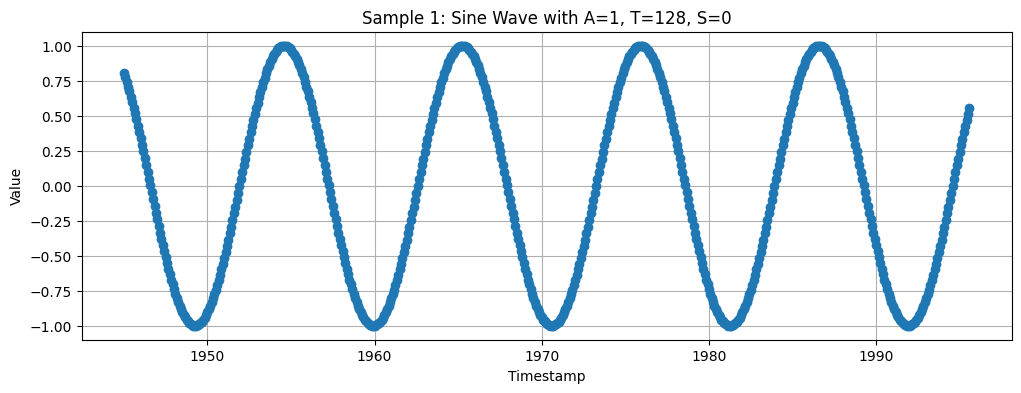

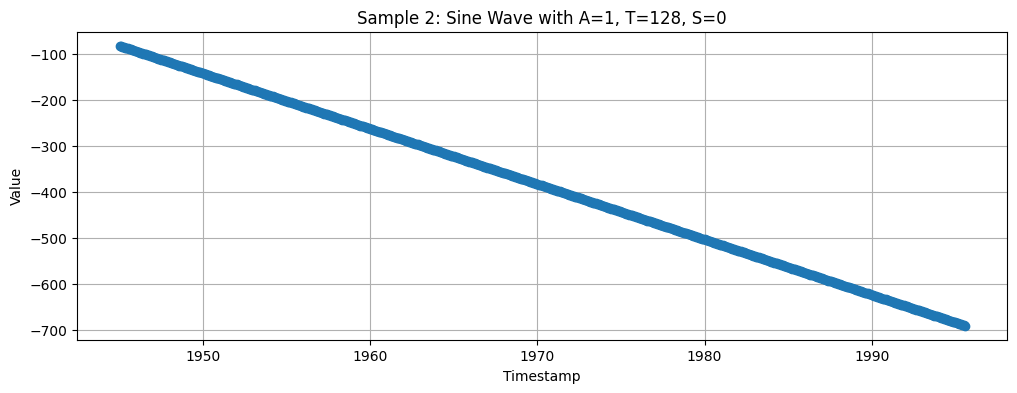

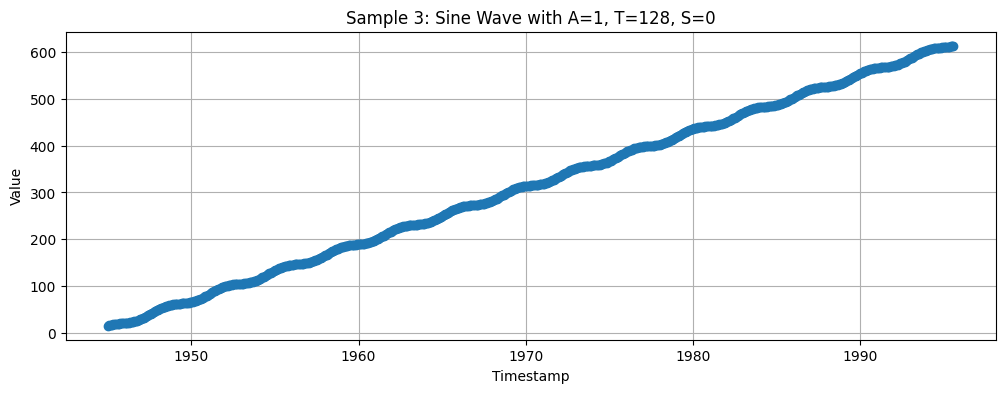

In [14]:
def plot_samples(x, y, list_of_params, m, num_samples=3):
    total_months = x.shape[1] + y.shape[1]
    start_date = pd.Timestamp('1945-01-01')

    for i in range(num_samples):
        # Identify which (A, T, S) tuple this sample belongs to
        param_index = i // m
        A, T, S = list_of_params[param_index]
        
        # Combine input and output
        full_series = np.concatenate([x[i], y[i]])
        # Create timestamps
        dates = [start_date + DateOffset(months=j) for j in range(total_months)]
        # Create DataFrame for plotting
        df = pd.DataFrame({
            'timestamp': dates,
            'value': full_series
        })
        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(df['timestamp'], df['value'], marker='o')
        plt.title(f"Sample {i+1}: Sine Wave with A={A}, T={T}, S={S}")
        plt.xlabel("Timestamp")
        plt.ylabel("Value")
        plt.grid(True)
        plt.show()
        
params = [(1, 128, 0), (0, 128, -1), (5, 42, 1)]
x, y = generate(params, 1)
plot_samples(x, y, params, 5)

# TimeGPT only accepts dataframe type inputs

In [6]:
def convert_to_df(x, is_input=True, start_date='1945-01-01', L=96):
    if is_input:
        base_date = pd.Timestamp(start_date)
    else:
        # Offset by L months for outputs
        base_date = pd.Timestamp(start_date) + DateOffset(months=L)

    n = len(x)
    dates = [base_date + DateOffset(months=i) for i in range(n)]
    if is_input:
        df = pd.DataFrame({
            'timestamp': dates,
            'value': x
        })
    else:
        df = pd.DataFrame({
            'timestamp': dates,
            'TimeGPT': x
        })
    return df

def convert_to_array(df):
    return df['TimeGPT'].values

# We attach a linear head to TimeGPT, experiment with different layers for finetuning

In [7]:
class TimeSeriesModel(nn.Module):
    def __init__(self, C, L, dropout_rate = 0.3):
        super(TimeSeriesModel, self).__init__()
        self.C = C
        self.L = L
        # Define the linear head
        self.linear_head = nn.Sequential(
            nn.Linear(L, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),   # Dropout applied here
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),   # Dropout applied here
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),   # Dropout applied here
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, L)
        )

    def forward(self, x):
        device = x.device
        refined = self.linear_head(x)
        return refined

def precompute_forecasts(x, L = 96):
    forecasts = []
    for i in range(x.shape[0]):
        input_array = x[i]
        df_input = convert_to_df(input_array, is_input=True, start_date='1945-01-01', L=L)
        
        # Forecast using TimeGpt
        forecast_df = nixtla_client.forecast(
            df=df_input,
            h=L,
            freq='MS',
            time_col='timestamp',
            target_col='value'
        )

        # Convert forecast dataframe back to a NumPy array
        forecast_values = convert_to_array(forecast_df)
        forecasts.append(forecast_values)

    return np.array(forecasts)

In [9]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [10]:
def train_model(x, y, list_of_params, C = 512, L = 96, num_epochs=20, learning_rate=0.001):
    # Pre-compute forecasts for all x values
    print("\nLoading TimeGPT...")
    precomputed_forecasts = precompute_forecasts(x, L)

    # Create a new dataset with the pre-computed forecasts
    dataset = TimeSeriesDataset(precomputed_forecasts, y)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

    # Initialize the model
    model = TimeSeriesModel(C=C, L=L)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Train the entire model

    # Training loop
    print("\nStarting Training...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_x, batch_y in dataloader:
            # Convert numpy arrays to torch tensors
            batch_x = torch.tensor(batch_x, dtype=torch.float32).to(device)  # Shape: (batch_size, L)
            batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)  # Shape: (batch_size, L)

            optimizer.zero_grad()
            outputs = model(batch_x)  # Shape: (batch_size, L)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_x.size(0)

        epoch_loss /= len(dataset)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}')

    print("\nTraining Completed.")
    
    return model

In [11]:
def display_plot(model, list_of_params, C = 512, L = 96):
    model.eval()
    device = next(model.parameters()).device
    print("Displaying Plot")
    with torch.no_grad():
        A, T, S = random.choice(list_of_params)
        # Random phase shift
        phase_shift = np.random.uniform(0, T)
        # Generate input data
        months_passed = np.arange(C + L) + phase_shift
        sine_values = A * np.sin(2 * np.pi / T * months_passed)
        linear_values = S * months_passed
        values = sine_values + linear_values

        # Separate x and y
        x = values[:C]
        y_actual = values[C:C + L]

        # Convert to DataFrame for forecasting
        df_input = convert_to_df(x, is_input=True, start_date='1945-01-01', L=L)
        # Forecast using TimeGpt
        forecast_df = nixtla_client.forecast(
            df=df_input,
            h=L,
            freq='MS',
            time_col='timestamp',
            target_col='value'
        )
        forecast_values = convert_to_array(forecast_df)

        # Convert forecast to tensor and pass through linear head
        forecast_tensor = torch.tensor(forecast_values, dtype=torch.float32).to(device).unsqueeze(0)  # Shape: (1, L)
        y_pred = model.linear_head(forecast_tensor).squeeze(0).cpu().numpy() 
        df_output = convert_to_df(y_pred, is_input = False, start_date='1945-01-01', L=C)
        return model, df_input, df_output

In [18]:
def evaluate_model(model, list_of_params, C=512, L=96, num_evaluations=100):
    
    model.eval()
    mse_loss = nn.MSELoss()
    total_mse = 0.0
    
    device = next(model.parameters()).device

    print("\nStarting Evaluation...")
    with torch.no_grad():
        for _ in range(num_evaluations):
            # Randomly select a parameter
            A, T, S = random.choice(list_of_params)
            # Random phase shift
            phase_shift = np.random.uniform(0, T)
            # Generate input data
            months_passed = np.arange(C + L) + phase_shift
            sine_values = A * np.sin(2 * np.pi / T * months_passed)
            linear_values = S * months_passed
            values = sine_values + linear_values
            
            # Separate x and y
            x = values[:C]
            y_actual = values[C:C + L]

            # Convert to DataFrame for forecasting
            df_input = convert_to_df(x, is_input=True, start_date='1945-01-01', L=L)
            # Forecast using TimeGpt
            forecast_df = nixtla_client.forecast(
                df=df_input,
                h=L,
                freq='MS',
                time_col='timestamp',
                target_col='value'
            )
            forecast_values = convert_to_array(forecast_df)

            # Convert forecast to tensor and pass through linear head
            forecast_tensor = torch.tensor(forecast_values, dtype=torch.float32).to(device).unsqueeze(0)  # Shape: (1, L)
            y_pred = model.linear_head(forecast_tensor).squeeze(0).cpu().numpy()  # Shape: (L,)

            # Compute MSE for this sample
            mse = mse_loss(torch.tensor(y_actual, dtype=torch.float32), torch.tensor(y_pred, dtype=torch.float32))
            total_mse += mse.item()

    average_mse = total_mse / num_evaluations
    return average_mse


In [19]:
def evaluate_unseen(model, list_of_params, C=512, L=96, num_evaluations=100):
    
    model.eval()
    mse_loss = nn.MSELoss()
    total_mse = 0.0
    
    device = next(model.parameters()).device

    print("\nStarting Evaluation...")
    with torch.no_grad():
        for _ in range(num_evaluations):
            # Randomly select a parameter
            A = 1
            S = 0
            T = random.randint(64, 512)
            # Random phase shift
            phase_shift = np.random.uniform(0, T)
            # Generate input data
            months_passed = np.arange(C + L) + phase_shift
            sine_values = A * np.sin(2 * np.pi / T * months_passed)
            linear_values = S * months_passed
            values = sine_values + linear_values
            
            # Separate x and y
            x = values[:C]
            y_actual = values[C:C + L]

            # Convert to DataFrame for forecasting
            df_input = convert_to_df(x, is_input=True, start_date='1945-01-01', L=L)
            # Forecast using TimeGpt
            forecast_df = nixtla_client.forecast(
                df=df_input,
                h=L,
                freq='MS',
                time_col='timestamp',
                target_col='value'
            )
            forecast_values = convert_to_array(forecast_df)

            # Convert forecast to tensor and pass through linear head
            forecast_tensor = torch.tensor(forecast_values, dtype=torch.float32).to(device).unsqueeze(0)  # Shape: (1, L)
            y_pred = model.linear_head(forecast_tensor).squeeze(0).cpu().numpy()  # Shape: (L,)

            # Compute MSE for this sample
            mse = mse_loss(torch.tensor(y_actual, dtype=torch.float32), torch.tensor(y_pred, dtype=torch.float32))
            total_mse += mse.item()

    average_mse = total_mse / num_evaluations
    return average_mse

# Run the code on functions from the same classes as training, and different classes

Generated Parameters (A, T, S):
Param 1: A=1, T=321, S=0
Param 2: A=1, T=281, S=0
Param 3: A=1, T=271, S=0
Param 4: A=1, T=216, S=0
Param 5: A=1, T=294, S=0
Param 6: A=1, T=92, S=0
Param 7: A=1, T=454, S=0
Param 8: A=1, T=478, S=0
Param 9: A=1, T=177, S=0
Param 10: A=1, T=94, S=0
Param 11: A=1, T=113, S=0
Param 12: A=1, T=496, S=0
Param 13: A=1, T=321, S=0
Param 14: A=1, T=301, S=0
Param 15: A=1, T=461, S=0
Param 16: A=1, T=324, S=0
Param 17: A=1, T=458, S=0
Param 18: A=1, T=480, S=0
Param 19: A=1, T=204, S=0
Param 20: A=1, T=451, S=0
Param 21: A=1, T=155, S=0
Param 22: A=1, T=359, S=0
Param 23: A=1, T=289, S=0
Param 24: A=1, T=123, S=0
Param 25: A=1, T=402, S=0
Param 26: A=1, T=267, S=0
Param 27: A=1, T=183, S=0
Param 28: A=1, T=374, S=0
Param 29: A=1, T=102, S=0
Param 30: A=1, T=320, S=0
Param 31: A=1, T=145, S=0
Param 32: A=1, T=477, S=0
Param 33: A=1, T=141, S=0
Param 34: A=1, T=197, S=0
Param 35: A=1, T=486, S=0
Param 36: A=1, T=274, S=0
Param 37: A=1, T=355, S=0
Param 38: A=1, T=

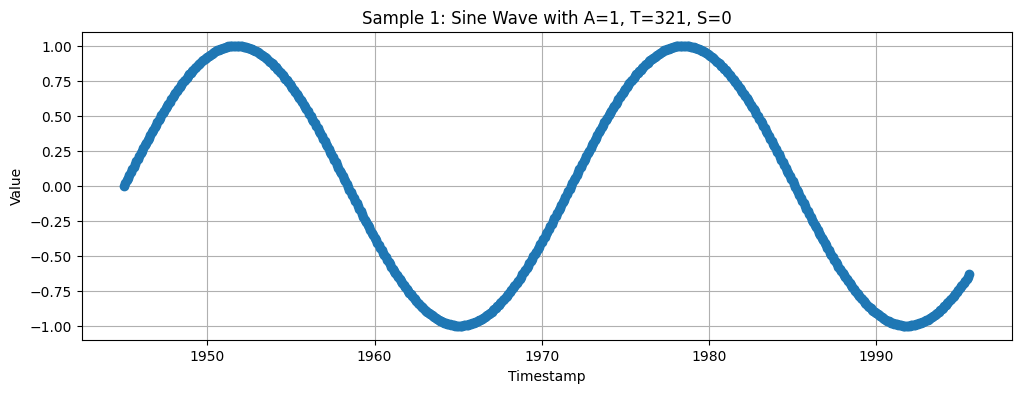

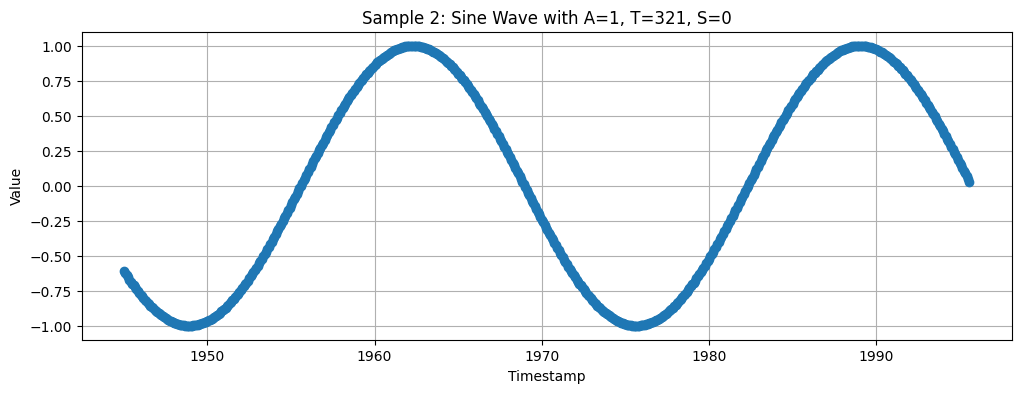

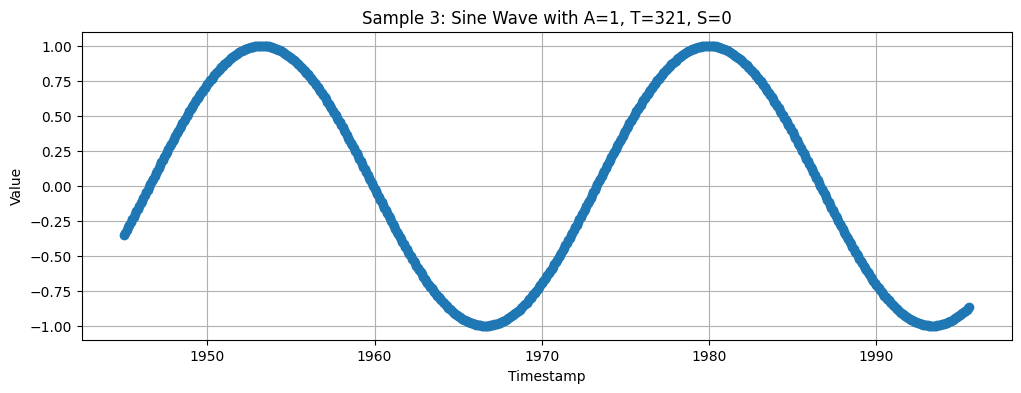

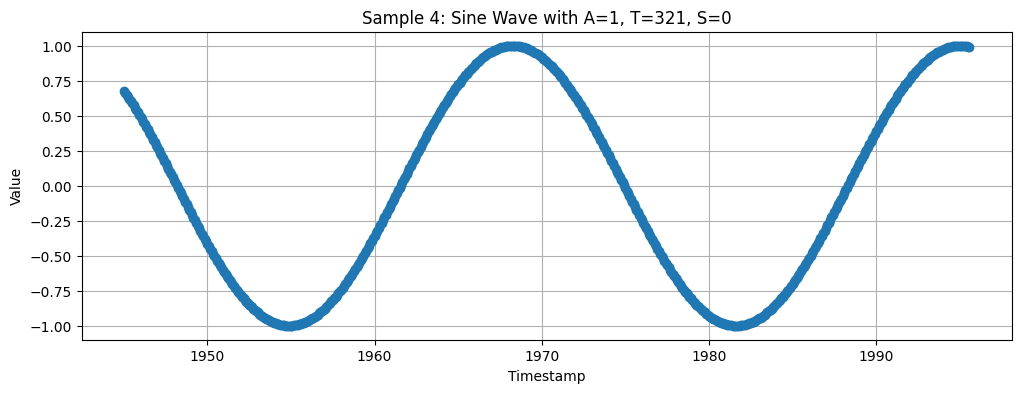

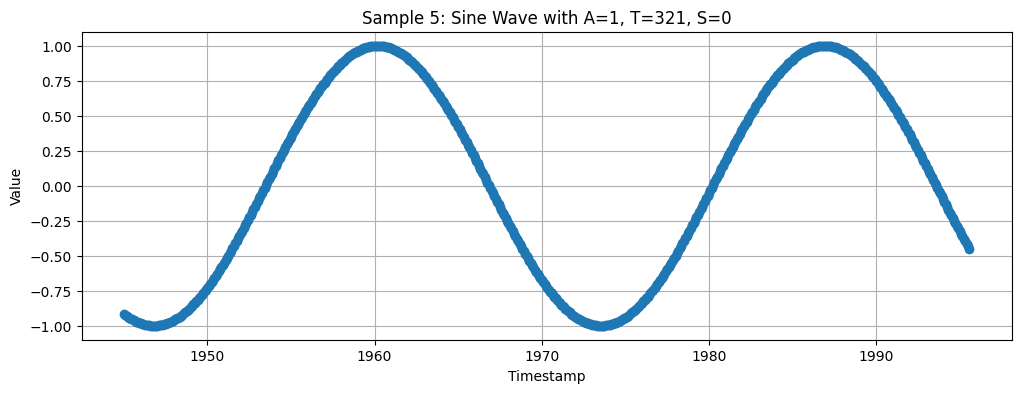


Loading TimeGPT...

Starting Training...
Epoch 1/50, Loss: 0.385711


/tmp/ipykernel_30/325816468.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_x = torch.tensor(batch_x, dtype=torch.float32).to(device)  # Shape: (batch_size, L)
/tmp/ipykernel_30/325816468.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_y = torch.tensor(batch_y, dtype=torch.float32).to(device)  # Shape: (batch_size, L)


Epoch 5/50, Loss: 0.254425
Epoch 10/50, Loss: 0.214696
Epoch 15/50, Loss: 0.190326
Epoch 20/50, Loss: 0.184262
Epoch 25/50, Loss: 0.182387
Epoch 30/50, Loss: 0.179089
Epoch 35/50, Loss: 0.172572
Epoch 40/50, Loss: 0.165200
Epoch 45/50, Loss: 0.167334
Epoch 50/50, Loss: 0.162265

Training Completed.

Starting Evaluation...
Average MSE over 200 evaluations: 0.176756

Starting Evaluation...
Average MSE over 200 evaluations, not belonging to classes: 0.160417
Displaying Plot


In [20]:
def run():
    # Parameters
    num_params = 50
    m = 20  # Number of instances per (A, T, S) tuple
    C = 512  # Number of input months
    L = 96  # Number of output months
    start_date = '1945-01-01'
    learning_rate = 1e-3
    num_epochs = 50

    # 1. Generate a random list of 5 params with A=1, S=0, T random between 12 and 36
    list_of_params = []
    for _ in range(num_params):
        A = 1
        S = 0
        T = random.randint(64, 512)
        list_of_params.append((A, T, S))
    print("Generated Parameters (A, T, S):")
    for idx, param in enumerate(list_of_params):
        print(f"Param {idx+1}: A={param[0]}, T={param[1]}, S={param[2]}")

    # 2. Generate 20 instances of each function
    x, y = generate(list_of_params=list_of_params, m=m, C=C, L=L)
    print(f"\nGenerated data: x shape = {x.shape}, y shape = {y.shape}")

    # Optional: Plot a few samples to ensure it's working
    plot_samples(x, y, list_of_params, m, num_samples=5)

    model = train_model(x, y, list_of_params, C, L, num_epochs)
    average_mse = evaluate_model(model, list_of_params, C=C, L=L, num_evaluations=200)
    print(f'Average MSE over 200 evaluations: {average_mse:.6f}')
    average_mse = evaluate_model(model, list_of_params, C=C, L=L, num_evaluations=200)
    print(f'Average MSE over 200 evaluations, not belonging to classes: {average_mse:.6f}')
    return display_plot(model, list_of_params, C, L)

model_trained, x, y = run()

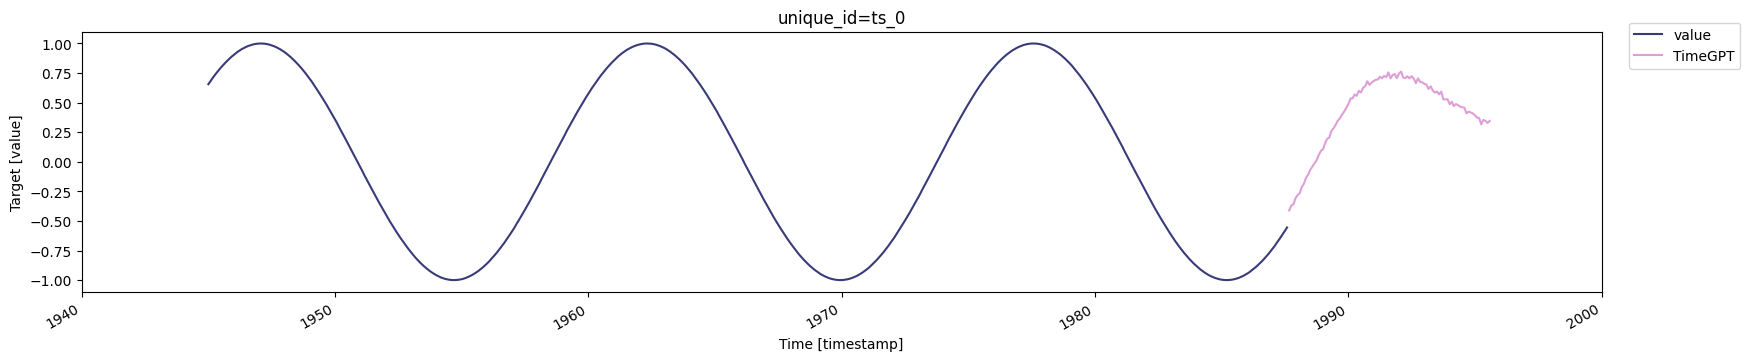

In [21]:
nixtla_client.plot(x, y, time_col='timestamp', target_col='value')